In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# 1. 데이터 로드 및 증강
df = pd.read_csv('lotto.csv')
numbers = df.iloc[:, 1:7].values  # 번호1 ~ 번호6

# 번호 빈도 계산
def calculate_number_frequency(numbers):
    flattened = numbers.flatten()
    unique, counts = np.unique(flattened, return_counts=True)
    frequency = dict(zip(unique, counts))
    return frequency

number_frequency = calculate_number_frequency(numbers)

# 데이터 증강: 번호 빈도를 고려한 증강
def augment_data(numbers, num_augmentations=5, frequency=None):
    augmented_data = []
    for row in numbers:
        for _ in range(num_augmentations):
            augmented_row = []
            for num in row:
                # 번호 빈도 기반 증강
                if frequency and np.random.rand() < frequency.get(num, 1) / max(frequency.values()):
                    augmented_num = np.clip(num + np.random.randint(-2, 3), 1, 45)
                else:
                    augmented_num = np.clip(num + np.random.randint(-1, 2), 1, 45)
                augmented_row.append(augmented_num)
            augmented_data.append(augmented_row)
    return np.array(augmented_data)

augmented_numbers = augment_data(numbers, num_augmentations=5, frequency=number_frequency)

# 시계열 데이터 생성
def create_time_series_data(numbers, lookback=5):
    X, y = [], []
    for i in range(lookback, len(numbers)):
        X.append(numbers[i-lookback:i])  # Lookback 기간의 번호 시퀀스
        y.append(numbers[i])  # 타겟 번호
    return np.array(X), np.array(y)

lookback = 5
X, y = create_time_series_data(augmented_numbers, lookback)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 정규화
X_train_scaled = X_train / 45.0
X_test_scaled = X_test / 45.0
y_train_scaled = y_train / 45.0
y_test_scaled = y_test / 45.0

In [3]:
# 2. Transformer 모델 정의 (구조 개선)
def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=8, key_dim=64)(inputs, inputs)  # Attention Head 증가
    x = LayerNormalization()(x)
    x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)  # 추가 Attention Layer
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)  # Dense Layer 크기 증가
    x = Dropout(0.3)(x)
    outputs = Dense(6, activation='sigmoid')(x)  # 6개의 Lotto 번호 출력
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

transformer_model = build_transformer_model((lookback, 6))

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [4]:
# LSTM 모델 학습 (history 저장)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = transformer_model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


2025-01-28 19:20:02.277554: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


145/145 [==============================] - 4s 25ms/step - loss: 0.0278 - mae: 0.1316 - val_loss: 0.0221 - val_mae: 0.1205
Epoch 2/50
145/145 [==============================] - 4s 26ms/step - loss: 0.0222 - mae: 0.1191 - val_loss: 0.0203 - val_mae: 0.1149
Epoch 3/50
145/145 [==============================] - 3s 23ms/step - loss: 0.0204 - mae: 0.1134 - val_loss: 0.0193 - val_mae: 0.1120
Epoch 4/50
145/145 [==============================] - 3s 23ms/step - loss: 0.0198 - mae: 0.1116 - val_loss: 0.0190 - val_mae: 0.1118
Epoch 5/50
145/145 [==============================] - 3s 23ms/step - loss: 0.0192 - mae: 0.1098 - val_loss: 0.0191 - val_mae: 0.1121
Epoch 6/50
145/145 [==============================] - 3s 22ms/step - loss: 0.0191 - mae: 0.1092 - val_loss: 0.0183 - val_mae: 0.1093
Epoch 7/50
145/145 [==============================] - 4s 28ms/step - loss: 0.0186 - mae: 0.1077 - val_loss: 0.0180 - val_mae: 0.1076
Epoch 8/50
145/145 [==============================] - 3s 24ms/step - loss: 0.018

In [5]:
# 3. 기존 모델(XGBoost, LightGBM, RandomForest, CatBoost) 학습
xgboost_models, lightgbm_models, randomforest_models, catboost_models = [], [], [], []
for i in range(6):
    # XGBoost
    xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    xgb.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, i])
    xgboost_models.append(xgb)

    # LightGBM
    lgb = LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
    lgb.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, i])
    lightgbm_models.append(lgb)

    # RandomForest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, i])
    randomforest_models.append(rf)

    # CatBoost
    cat = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, random_state=42, verbose=0)
    cat.fit(X_train.reshape(X_train.shape[0], -1), y_train[:, i])
    catboost_models.append(cat)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 4620, number of used features: 30
[LightGBM] [Info] Start training from score 6.888745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [6]:
# 4. 가중치 기반 앙상블 예측 함수
def weighted_ensemble_predict(X, weights, transformer_model, xgboost_models, lightgbm_models, randomforest_models, catboost_models):
    transformer_preds = transformer_model.predict(X / 45.0) * 45.0
    xgboost_preds = np.array([model.predict(X.reshape(X.shape[0], -1)) for model in xgboost_models]).T
    lightgbm_preds = np.array([model.predict(X.reshape(X.shape[0], -1)) for model in lightgbm_models]).T
    randomforest_preds = np.array([model.predict(X.reshape(X.shape[0], -1)) for model in randomforest_models]).T
    catboost_preds = np.array([model.predict(X.reshape(X.shape[0], -1)) for model in catboost_models]).T
    ensemble_preds = (
        weights[0] * transformer_preds +
        weights[1] * xgboost_preds +
        weights[2] * lightgbm_preds +
        weights[3] * randomforest_preds +
        weights[4] * catboost_preds
    )
    return np.round(ensemble_preds).astype(int)

In [7]:
# 예측 후처리 최적화 (중복 호출 방지)
def adjust_predictions(predictions, n_numbers=6):
    adjusted_predictions = []
    for pred in predictions:
        pred = np.clip(pred, 1, 45)  # 번호를 1~45 범위로 제한
        unique_pred = sorted(set(pred))  # 중복 제거 후 정렬
        while len(unique_pred) < n_numbers:  # 부족한 번호를 채움
            new_num = np.random.randint(1, 46)
            if new_num not in unique_pred:
                unique_pred.append(new_num)
        adjusted_predictions.append(sorted(unique_pred[:n_numbers]))
    return np.array(adjusted_predictions)

# 5. 가중치 최적화
def optimize_weights(weights, X, y_true, transformer_model, xgboost_models, lightgbm_models, randomforest_models, catboost_models):
    y_pred = weighted_ensemble_predict(X, weights, transformer_model, xgboost_models, lightgbm_models, randomforest_models, catboost_models)
    y_pred = adjust_predictions(y_pred)
    mae = mean_absolute_error(y_true.reshape(-1), y_pred.reshape(-1))
    return mae

initial_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
bounds = [(0, 1)] * 5
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = minimize(
    optimize_weights,
    initial_weights,
    args=(X_test, y_test, transformer_model, xgboost_models, lightgbm_models, randomforest_models, catboost_models),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimized_weights = result.x
print(f"Optimized Weights: {optimized_weights}")

37/37 [==============================] - 0s 8ms/step
Optimized Weights: [0.2 0.2 0.2 0.2 0.2]


In [8]:
# Convert predictions to binary format for classification metrics
def convert_to_binary(y_true, y_pred):
    binary_true = np.zeros((len(y_true), 45))
    binary_pred = np.zeros((len(y_pred), 45))
    for i in range(len(y_true)):
        binary_true[i, y_true[i]-1] = 1
        binary_pred[i, y_pred[i]-1] = 1
    return binary_true, binary_pred

# 최적화된 가중치로 예측
final_predictions = weighted_ensemble_predict(
    X_test, optimized_weights, transformer_model,
    xgboost_models, lightgbm_models, randomforest_models, catboost_models
)

# 최종 예측 값에 한 번만 후처리 적용
final_predictions = adjust_predictions(final_predictions)

# Convert to binary format for classification metrics
binary_true, binary_pred = convert_to_binary(y_test, final_predictions)

def calculate_metrics(y_true, y_pred):
    """
    회귀 모델의 주요 성능 지표를 계산하는 함수
    
    Parameters:
        y_true: 실제 값
        y_pred: 예측된 값
        
    Returns:
        dictionary: 각종 성능 지표를 포함하는 딕셔너리
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    metrics = {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False),
        'r2': r2_score(y_true, y_pred)
    }
    return metrics

# 평가 메트릭 계산
metrics = calculate_metrics(y_test, final_predictions)

# 결과 출력
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")


37/37 [==============================] - 0s 8ms/step

Evaluation Metrics:
mae: 2.66
mse: 14.77
rmse: 3.82
r2: 0.66


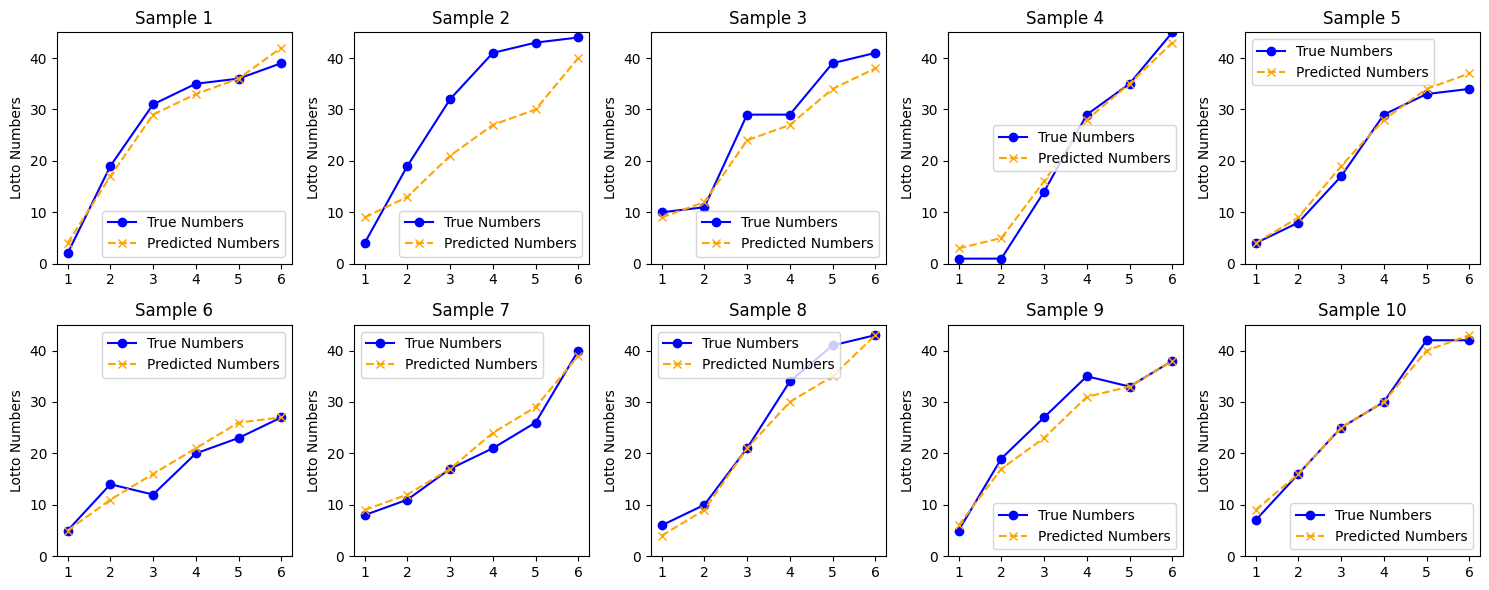

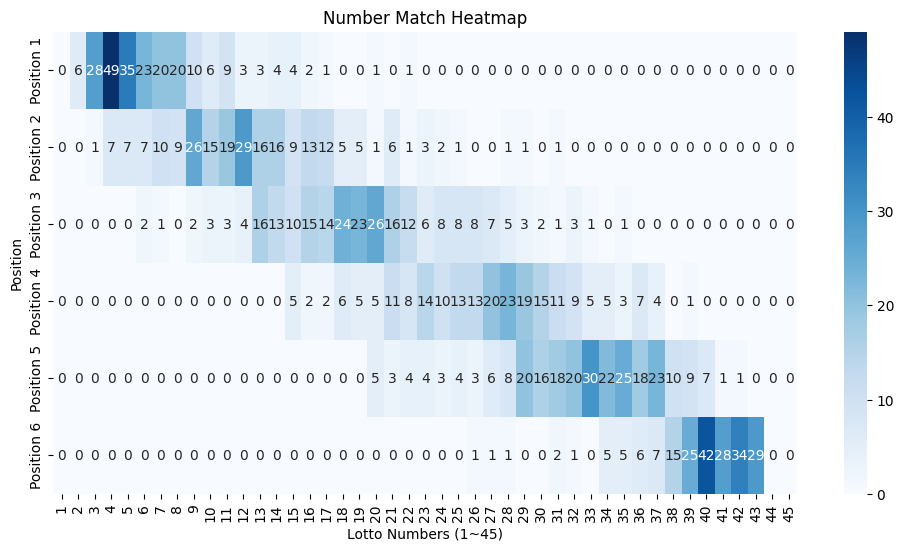

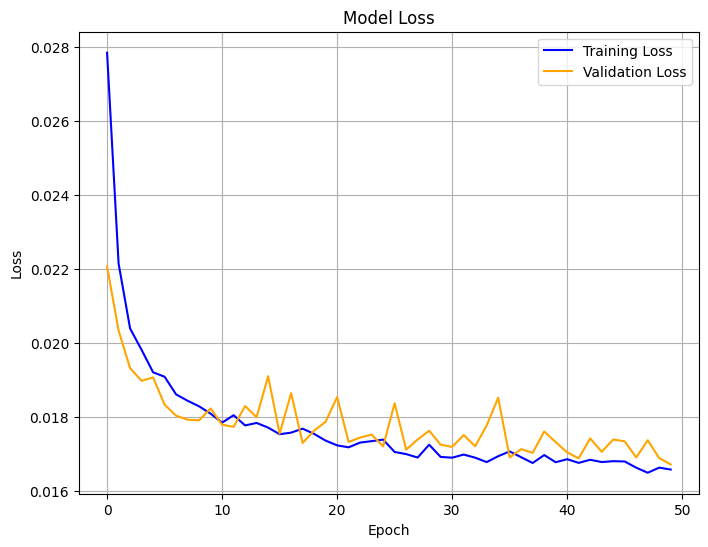

In [9]:
# 8. 시각화
# 예측 번호와 실제 번호 비교
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(y_true, y_pred, num_samples=10):
    plt.figure(figsize=(15, 6))
    for i in range(min(num_samples, len(y_true))):
        plt.subplot(2, 5, i + 1)
        true = y_true[i]
        pred = y_pred[i]

        plt.plot(range(1, 7), true, marker='o', label='True Numbers', linestyle='-', color='blue')
        plt.plot(range(1, 7), pred, marker='x', label='Predicted Numbers', linestyle='--', color='orange')
        plt.title(f"Sample {i + 1}")
        plt.ylim(0, 45)
        plt.xticks(range(1, 7))
        plt.ylabel("Lotto Numbers")
        plt.legend()

    plt.tight_layout()
    plt.show()

# 번호별 일치 개수 히트맵
def plot_match_heatmap(y_true, y_pred):
    match_counts = np.zeros((6, 45))
    for true, pred in zip(y_true, y_pred):
        for i in range(6):
            if pred[i] in true:
                match_counts[i, pred[i] - 1] += 1

    plt.figure(figsize=(12, 6))
    sns.heatmap(match_counts, annot=True, fmt=".0f", cmap="Blues", xticklabels=range(1, 46), yticklabels=[f"Position {i+1}" for i in range(6)])
    plt.title("Number Match Heatmap")
    plt.xlabel("Lotto Numbers (1~45)")
    plt.ylabel("Position")
    plt.show()

# Loss 변화 시각화
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 실행
plot_predictions(y_test, final_predictions, num_samples=10)
plot_match_heatmap(y_test, final_predictions)
plot_loss(history)

In [10]:
# 최적화된 가중치로 예측
final_predictions = weighted_ensemble_predict(
    X_test, optimized_weights, transformer_model,
    xgboost_models, lightgbm_models, randomforest_models, catboost_models
)

# 디버깅: 앙상블 예측 결과 확인
print("\nRaw Ensemble Predictions (Before Adjustment):")
print(final_predictions[:5])  # 샘플 몇 개 출력

# 예측 후처리 최적화
def adjust_predictions(predictions, n_numbers=6):
    adjusted_predictions = []
    for pred in predictions:
        pred = np.clip(pred, 1, 45)  # 번호를 1~45 범위로 제한
        unique_pred = sorted(set(pred))  # 중복 제거 후 정렬
        while len(unique_pred) < n_numbers:  # 부족한 번호를 채움
            new_num = np.random.randint(1, 46)
            if new_num not in unique_pred:
                unique_pred.append(new_num)
        adjusted_predictions.append(sorted(unique_pred[:n_numbers]))
    return np.array(adjusted_predictions)

# 후처리된 최종 예측 값
final_predictions = adjust_predictions(final_predictions)

# 디버깅: 최종 조정된 예측 결과 확인
print("\nAdjusted Predictions (After Adjustment):")
print(final_predictions[:5])  # 샘플 몇 개 출력

# 평가 메트릭 계산
metrics = calculate_metrics(y_test, final_predictions)

# 결과 출력
print("\nEvaluation Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.2f}" if isinstance(value, float) else f"{key}: {value}")

# 디버깅: 다음 회차 예측 결과 확인
next_prediction = weighted_ensemble_predict(
    X[-1].reshape(1, lookback, 6), optimized_weights,
    transformer_model, xgboost_models, lightgbm_models,
    randomforest_models, catboost_models
)
next_prediction = adjust_predictions(next_prediction)
print(f"\nPredicted next Lotto numbers: {next_prediction[0]}")


37/37 [==============================] - 0s 8ms/step

Raw Ensemble Predictions (Before Adjustment):
[[ 4 17 29 33 36 42]
 [ 9 13 21 27 30 40]
 [ 9 12 24 27 34 38]
 [ 3  5 16 28 35 43]
 [ 4  9 19 28 34 37]]

Adjusted Predictions (After Adjustment):
[[ 4 17 29 33 36 42]
 [ 9 13 21 27 30 40]
 [ 9 12 24 27 34 38]
 [ 3  5 16 28 35 43]
 [ 4  9 19 28 34 37]]

Evaluation Metrics:
mae: 2.66
mse: 14.78
rmse: 3.82
r2: 0.66
1/1 [==============================] - 0s 87ms/step

Predicted next Lotto numbers: [ 9 22 27 31 35 39]
